# Brunner-Munzel検定について

* 黒木玄
* 2022-08-05

__文献__

* E. Brunner and U. Munzel. The nonparametric Behrens-Fisher problem: Asymptotic theory and a small-sample
approximation. Biometrical Journal, 42:17–25, 2000.
\[[pdf](https://www.researchgate.net/profile/Edgar-Brunner/publication/264799502_Nonparametric_Hypotheses_and_Rank_Statistics_for_Unbalanced_Factorial_Designs/links/5756a00408ae155a87bc5c8c/Nonparametric-Hypotheses-and-Rank-Statistics-for-Unbalanced-Factorial-Designs.pdf)\]

* Karin Neubert and Edgar Brunner, A studentized permutation test for the non-parametric Behrens-Fisher problem, Computational Statistics and Data Analysis, Vol. 51, pp. 5192-5204 (2007).
https://doi.org/10.1016/j.csda.2006.05.024

* Claus P. Nowak, Markus Pauly, Edgar Brunner. The nonparametric Behrens-Fisher problem in small samples.
https://arxiv.org/abs/2208.01231

In [1]:
using Base.Threads
using BenchmarkTools
using Distributions
using PrettyPrinting
using QuadGK
using Random
using RCall
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, size=(400, 250),
    titlefontsize=10, guidefontsize=8, tickfontsize=6)

x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
"""
    nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])

`[1,2,…,n]` からの重複無しの `t` 個の組み合わせ `c` をすべて生成したい.

`nextcombination!(n, t, c)` は配列で表現された組み合わせ `c` をその次の組み合わせに書き換えて, `c` を返す.

初期条件を `c = typeof(t)[min(t-1, i) for i in 1:t]` にすると, `binomial(n, t)` 回の `nextcombination!(n, t, c)` ですべての組み合わせが生成される.
"""
function nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])
    t == 0 && return c
    @inbounds for i in t:-1:1
        c[i] += 1
        c[i] > (n - (t - i)) && continue
        for j in i+1:t
            c[j] = c[j-1] + 1
        end
        break
    end
    c
end

"""
    mycombinations!(n::Integer, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, `[1,2,…,n]` からの重複無しの `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(n::Integer, t, c)
    for i in 1:t c[i] = min(t - 1, i) end
    (nextcombination!(n, t, c) for _ in 1:binomial(n, t))
end

"""
    mycombinations!(a, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, 配列 `a` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(a, t, c)
    t < 0 && (t = length(a) + 1)
    (view(a, indices) for indices in mycombinations!(length(a), t, c))
end

"""
    mycombinations(x, t)

`x` が整数ならば `[1,2,…,x]` からの, `x` が配列ならば `x` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
mycombinations(x, t) = mycombinations!(x, t, Vector{typeof(t)}(undef, t))

mycombinations

In [3]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [4]:
function findpositive(f, a, b; maxsplit = 30)
    @assert f(a) < 0
    @assert f(b) < 0
    c = (a + b)/2
    f(c) > 0 && return c
    w = b - a
    for k in 2:maxsplit
        for d in range(w/2^(k+1), w/2-w/2^(k+1), step=w/2^k)
            x = c + d
            f(x) > 0 && return x 
            x = c - d
            f(x) > 0 && return x 
        end
    end
    error("k > maxplit = $maxsplit")
end

f(x) = abs(x) < 1e-4 ? 1.0 : -1.0

@time findpositive(f, -100abs(randn()), 20abs(randn()))

  0.000123 seconds


1.4286701420118675e-5

In [5]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx::UnivariateDistribution, disty::UnivariateDistribution;
        p=0.5)
    find_zero(a -> prob_x_le_y(distx, disty, a) - p, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [6]:
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

function statistics_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        RRx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        RRy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(RRy) - mean(RRx) + n)/(m + n)
    sx2, sy2 = var(RRx)/n^2, var(RRy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

function pvalue_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, RRx, RRy; p).pvalue
end

function tieshift(X::AbstractVector, Y::AbstractVector; p=0.5)
    locmin = minimum(X) - maximum(Y) - 0.1
    locmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (locmin, locmax))
end

function brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, RRx, RRy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_location(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, RRx, RRy; p)
    end
    locmin = minimum(X) - maximum(Y) - 0.1
    locmax = maximum(X) - minimum(Y) + 0.1
    loccent = tieshift(X, Y; p)
    #if pvalue_location(loccent) - α < 0
    #    loccent = findpositive(a -> pvalue_location(a) - α, locmin, locmax; maxsplit)
    #end
    confint_location = [
        find_zero(a -> pvalue_location(a) - α, (locmin, loccent))
        find_zero(a -> pvalue_location(a) - α, (loccent, locmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location,
        pvalue_location, locmin, locmax)
end

function show_plot_brunner_munzel(X, Y,
        RRx = similar(X, Float64),
        RRy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location,
        pvalue_location, locmin, locmax) = brunner_munzel(X, Y, RRx, RRy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p, confint_location))
    println()
    @show median(X) median(Y)
    plot(pvalue_location, locmin, locmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of location")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [7]:
X = randn(10)
Y = randn(10)
@show locmin = minimum(X) - maximum(Y) - 1
@show locmax = maximum(X) - minimum(Y) + 1
pvalue_brunner_munzel(X, Y)

locmin = (minimum(X) - maximum(Y)) - 1 = -3.7044537176987626
locmax = (maximum(X) - minimum(Y)) + 1 = 4.089879080061887


0.35051671143827723

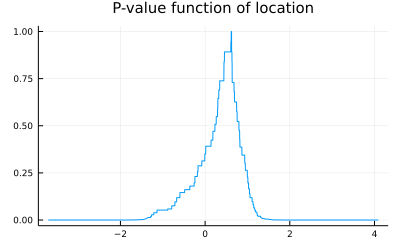

In [8]:
plot(a -> pvalue_brunner_munzel(X, Y .+ a), locmin, locmax;
    label="", title="P-value function of location")

https://okumuralab.org/~okumura/stat/brunner-munzel.html

```R
x = c(1,2,1,1,1,1,1,1,1,1,2,4,1,1)
y = c(3,3,4,3,1,2,3,1,1,5,4)
brunnermunzel.test(x, y)

data:  x and y
Brunner-Munzel Test Statistic = 3.1375, df = 17.683, p-value = 0.005786
95 percent confidence interval:
 0.5952169 0.9827052
sample estimates:
P(X<Y)+.5*P(X=Y) 
        0.788961 
```

(phat = 0.788961038961039,
 sehat = 0.09210009046816862,
 tvalue = 3.1374674823029505,
 df = 17.682841979481545,
 p = 0.5,
 pvalue = 0.005786208666151463,
 α = 0.05,
 confint_p = [0.5952168642537363, 0.9827052136683416],
 confint_location = [-2.0000000000000004, -5.551115123125783e-17])
median(X) = 1.0
median(Y) = 3.0


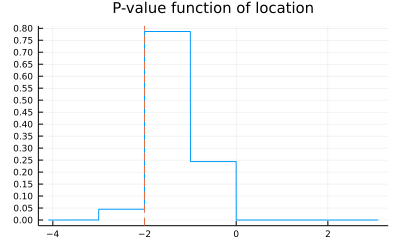

In [9]:
X = [1,2,1,1,1,1,1,1,1,1,2,4,1,1]
Y = [3,3,4,3,1,2,3,1,1,5,4]
show_plot_brunner_munzel(X, Y)

In [10]:
"""
    complementcomb!(comb, ccomb)

`comb` は {1,2,…,N} から重複無しに m 個を選ぶ組み合わせを表す配列で, `comb` の中で数は小さな順に並んでいることを仮定する.  この函数は `ccomb` に `comb` の補集合を格納し, `ccomb` を返す.
"""
function complementcomb!(ccomb::AbstractVector, comb::AbstractVector)
    N = length(comb) + length(ccomb)
    k = 0
    a = 0
    @inbounds for b in comb
        for i in a+1:b-1
            k += 1
            ccomb[k] = i
        end
        a = b
    end
    @inbounds for i in a+1:N
        k +=1
        ccomb[k] = i
    end
    ccomb
end

complementcomb(N, comb::AbstractVector) =
    complementcomb!(similar(comb, N - length(comb)), comb)

complementcomb (generic function with 1 method)

In [11]:
N = 10
comb = [2, 4, 5, 8]
ccomb = similar(comb, N - length(comb))
@btime complementcomb!($ccomb, $comb);

  13.627 ns (0 allocations: 0 bytes)


In [12]:
N, m = 5, 3
ccomb = Vector{Int}(undef, N-m)
[(copy(comb), copy(complementcomb!(ccomb, comb))) for comb in mycombinations(1:N, m)]

10-element Vector{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3], [4, 5])
 ([1, 2, 4], [3, 5])
 ([1, 2, 5], [3, 4])
 ([1, 3, 4], [2, 5])
 ([1, 3, 5], [2, 4])
 ([1, 4, 5], [2, 3])
 ([2, 3, 4], [1, 5])
 ([2, 3, 5], [1, 4])
 ([2, 4, 5], [1, 3])
 ([3, 4, 5], [1, 2])

In [13]:
N, m = 5, 3
ccomb = Vector{Int}(undef, N-m)
[(copy(comb), complementcomb(N, comb)) for comb in mycombinations(1:N, m)]

10-element Vector{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3], [4, 5])
 ([1, 2, 4], [3, 5])
 ([1, 2, 5], [3, 4])
 ([1, 3, 4], [2, 5])
 ([1, 3, 5], [2, 4])
 ([1, 4, 5], [2, 3])
 ([2, 3, 4], [1, 5])
 ([2, 3, 5], [1, 4])
 ([2, 4, 5], [1, 3])
 ([3, 4, 5], [1, 2])

In [14]:
"""
    permutation_tvalues_brunner_munzel(X, Y;
        XandY = Vector{Float64}(undef, length(X)+length(Y)),
        Tval = Vector{Float64}(undef, binomial(length(X)+length(Y), length(X)))
    )

Brunner-Munzel検定のt値を `[X; Y]` からインデックスの重複無しに `length(X)` 個取る組み合わせとその補集合への分割のすべてについて計算して, `Tval` に格納して返す.
"""
function permutation_tvalues_brunner_munzel(X, Y;
        XandY = Vector{Float64}(undef, length(X)+length(Y)),
        Tval = Vector{Float64}(undef, binomial(length(X)+length(Y), length(X)))
    )
    m, n = length(X), length(Y)
    N = m + n
    @views XandY[1:m] .= X
    @views XandY[m+1:N] .= Y
    allindices = 1:N
    RRx = similar(X, Float64)
    RRy = similar(Y, Float64)
    ccomb = Vector{Int}(undef, n)
    for (k, comb) in enumerate(mycombinations(1:N, m))
        complementcomb!(ccomb, comb)
        Tval[k] = statistics_brunner_munzel(
            view(XandY, comb), view(XandY, ccomb), RRx, RRy).tvalue
    end
    Tval
end

"""
    pvalue_brunner_munzel_perm(X, Y,
        Tval = permutation_tvalues_brunner_munzel(X, Y),
        tval = statistics_brunner_munzel(X, Y).tvalue;
        le = ⪅
    )

Brunner-Munzel検定のpermutation版のP値を返す.
"""
function pvalue_brunner_munzel_perm(X, Y,
        Tval = permutation_tvalues_brunner_munzel(X, Y),
        tval = statistics_brunner_munzel(X, Y).tvalue;
        le = ⪅
    )
    pvalue_perm = mean(T -> le(abs(tval), abs(T)), Tval)
end

pvalue_brunner_munzel_perm

https://okumuralab.org/~okumura/stat/brunner-munzel.html

```
bm = brunner.munzel.test(x, y)$statistic
n1 = length(x)
n2 = length(y)
N = n1 + n2
xandy = c(x, y)
foo = function(X) {
  brunner.munzel.test(xandy[X], xandy[-X])$statistic
}
z = combn(1:N, n1, foo)
mean(abs(z) >= abs(bm))
```

>結果は 0.008037645 となりました。

X = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1]
Y = [3, 3, 4, 3, 1, 2, 3, 1, 1, 5, 4]
(m, n) = (length(X), length(Y)) = (14, 11)
  4.634549 seconds (904.92 k allocations: 80.278 MiB, 0.54% gc time, 5.34% compilation time)
pvalue_brunner_munzel_perm(X, Y, Tval) = 0.008037645264055279


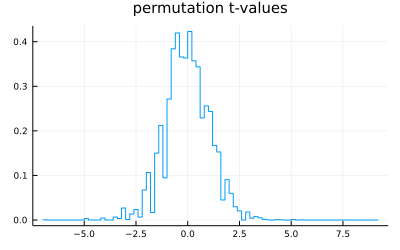

In [15]:
X = [1,2,1,1,1,1,1,1,1,1,2,4,1,1]
Y = [3,3,4,3,1,2,3,1,1,5,4]
@show X Y
@show m, n = length(X), length(Y)

Tval = @time permutation_tvalues_brunner_munzel(X, Y)
@show pvalue_brunner_munzel_perm(X, Y, Tval)
stephist(Tval; norm=true, bin=101, label="", title="permutation t-values")

https://github.com/toshi-ara/brunnermunzel/issues/14

https://github.com/toshi-ara/brunnermunzel/files/4395032/mwe.R.zip

In [16]:
R"""
library(brunnermunzel)
set.seed(1290)
reps = 100
xx = c()
yy = c()
pval_R = numeric(reps)
for (i in seq_len(reps)){
  x = rnorm(5)
  y = rnorm(5)
  
  xx = c(xx, x)
  yy = c(yy, y)
  
  res_bm_perm <- brunnermunzel.permutation.test(x,y)
  pval_R[i] <- res_bm_perm$p.value
}
"""

@rget xx yy pval_R
XX = reshape(xx, 5, 100)
YY = reshape(yy, 5, 100)

pval_J = zeros(100)
pval_J_le = zeros(100)
for i in 1:100
    pval_J[i]    = pvalue_brunner_munzel_perm(XX[:,i], YY[:,i]; le = ⪅)
    pval_J_le[i] = pvalue_brunner_munzel_perm(XX[:,i], YY[:,i]; le = ≤)
end

In [17]:
@show pval_J - pval_J_le;

pval_J - pval_J_le = [0.0, 0.0, 0.007936507936507936, 0.023809523809523808, 0.023809523809523808, 0.0793650793650793, 0.0, 0.0, 0.007936507936507936, 0.0357142857142857, 0.0, 0.015873015873015928, 0.015873015873015872, 0.0, 0.015873015873015872, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.023809523809523836, 0.015873015873015928, 0.011904761904761918, 0.0, 0.015873015873015928, 0.0, 0.003968253968253968, 0.0, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.015873015873015928, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.0, 0.007936507936507936, 0.007936507936507936, 0.011904761904761918, 0.007936507936507936, 0.03968253968253965, 0.0, 0.007936507936507936, 0.0, 0.05555555555555547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015872, 0.015873015873015872, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015928, 0.007936507936507964, 0.007936507936507964, 0.0, 0

In [18]:
idx = @show findall(pval_J .!= pval_J_le)
length(idx)

findall(pval_J .!= pval_J_le) = [3, 4, 5, 6, 9, 10, 12, 13, 15, 19, 21, 22, 23, 25, 27, 32, 34, 36, 40, 42, 44, 47, 48, 49, 50, 51, 53, 55, 68, 69, 71, 78, 79, 80, 82, 86, 89, 90, 92, 94]


40

In [19]:
@show pval_R - pval_J_le;

pval_R - pval_J_le = [0.0, 0.0, 0.007936507936507936, 0.023809523809523808, 0.023809523809523808, 0.0793650793650793, 0.0, 0.0, 0.007936507936507936, 0.0357142857142857, 0.0, 0.015873015873015928, 0.015873015873015872, 0.0, 0.015873015873015872, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.023809523809523836, 0.007936507936507908, 0.011904761904761918, 0.0, 0.015873015873015928, 0.0, 0.003968253968253968, 0.0, 0.0, 0.0, 0.0, 0.007936507936507936, 0.0, 0.00793650793650802, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.007936507936507908, 0.0, 0.0, 0.007936507936507936, 0.007936507936507936, 0.011904761904761918, 0.007936507936507936, 0.03968253968253965, 0.0, 0.007936507936507936, 0.0, 0.05555555555555547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015872, 0.015873015873015872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007936507936507908, 0.007936507936507964, 0.007936507936507964, 0.0, 0.00396825396825395

In [20]:
idx = @show findall(pval_R .!= pval_J_le)
length(idx)

findall(pval_R .!= pval_J_le) = [3, 4, 5, 6, 9, 10, 12, 13, 15, 19, 21, 22, 23, 25, 27, 32, 34, 36, 40, 42, 44, 47, 48, 49, 50, 51, 53, 55, 68, 69, 78, 79, 80, 82, 86, 89, 90, 92, 94]


39

In [21]:
@show pval_J - pval_R;

pval_J - pval_R = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00793650793650802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007936507936507908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015873015873015928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00793650793650802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
idx = @show findall(.!(pval_J .≈ pval_R))
length(idx)

findall(.!(pval_J .≈ pval_R)) = [22, 34, 71, 78]


4

In [23]:
all(pval_J .≥ pval_R .≥ pval_J_le)

true

なるほど！

https://github.com/toshi-ara/brunnermunzel/issues/14

に書いてあるように, 22, 34, 71 and 78 の4つで, 値が一致していない.

〇〇以下または〇〇以上の判定を $x \approx y$ のときも true にする必要があるのだが, その部分で違いが生じているものと思われる.

現時点では https://CRAN.R-project.org/package=brunnermunzel  にアクセスすると,

>Package ‘brunnermunzel’ was removed from the CRAN repository.
>
>Formerly available versions can be obtained from the [archive](https://cran.r-project.org/src/contrib/Archive/brunnermunzel/).
>
>Archived on 2022-03-04 as check problems were not corrected in time. , LENGTH_1 checks.
>
>A summary of the most recent check results can be obtained from the [check results archive](https://cran-archive.r-project.org/web/checks/2022/2022-03-04_check_results_brunnermunzel.html).
>
>Please use the canonical form https://CRAN.R-project.org/package=brunnermunzel to link to this page.

と表示される.

In [24]:
m, n = 10, 10
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
@show pval_brmu = pvalue_brunner_munzel(X, Y)
@show pval_perm = pvalue_brunner_munzel_perm(X, Y);

pval_brmu = pvalue_brunner_munzel(X, Y) = 0.5912503348524982
pval_perm = pvalue_brunner_munzel_perm(X, Y) = 0.5759271688064258


(phat = 0.75,
 sehat = 0.10056855914111178,
 tvalue = 2.485866379463735,
 df = 18.385702920172452,
 p = 0.5,
 pvalue = 0.022742714988590425,
 α = 0.05,
 confint_p = [0.5390305665719614, 0.9609694334280386],
 confint_location = [-2.4770370893730127, -0.3717172074086195])
median(X) = -0.5058729691113518
median(Y) = 1.1395412005826189


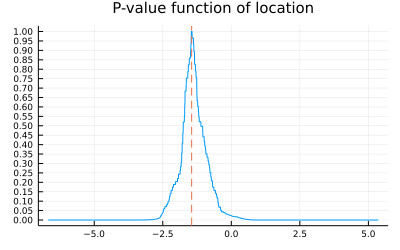

In [25]:
Random.seed!(4)

m, n = 10, 20
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

(phat = 0.675,
 sehat = 0.1049296617650541,
 tvalue = 1.667783895004246,
 df = 27.705176944214784,
 p = 0.5,
 pvalue = 0.10662428006873317,
 α = 0.05,
 confint_p = [0.45995823964489857, 0.8900417603551015],
 confint_location = [-2.2060635904773678, 0.3296238740154929])
median(X) = -0.17409123783026362
median(Y) = 0.8382134149102431


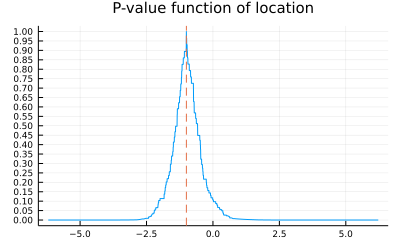

In [26]:
m, n = 10, 20
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

(phat = 0.43979999999999997,
 sehat = 0.05714122667226539,
 tvalue = -1.0535300606211744,
 df = 60.575330843208235,
 p = 0.5,
 pvalue = 0.2962824213806768,
 α = 0.05,
 confint_p = [0.3255228528192483, 0.5540771471807516],
 confint_location = [-0.3011419367780337, 1.0179208275627627])
median(X) = -0.0536449473157313
median(Y) = -0.6163649344394873


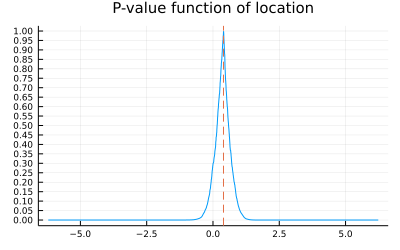

In [27]:
m, n = 100, 50
X, Y = rand(Normal(0, 1), m), rand(Normal(0, 2), n)
show_plot_brunner_munzel(X, Y)

(phat = 0.6725,
 sehat = 0.1005725567999867,
 tvalue = 1.715179622439735,
 df = 20.71835365424782,
 p = 0.5,
 pvalue = 0.10123190720539166,
 α = 0.05,
 confint_p = [0.46317465971191163, 0.8818253402880883],
 confint_location = [-10.999999999999998, 0.9999999999999997])
median(X) = 6.5
median(Y) = 14.5


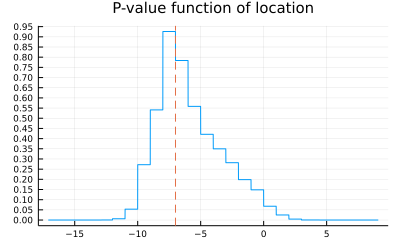

In [28]:
Random.seed!(4)

m, n = 10, 20
X, Y = rand(1:m, m), rand(1:n, n)
show_plot_brunner_munzel(X, Y)

(phat = 0.765,
 sehat = 0.08626255311649104,
 tvalue = 3.0720166564295583,
 df = 27.60349766038036,
 p = 0.5,
 pvalue = 0.004741546491682432,
 α = 0.05,
 confint_p = [0.5881847509519754, 0.9418152490480246],
 confint_location = [-8.999999999999998, -1.9999999999999993])
median(X) = 5.5
median(Y) = 12.0


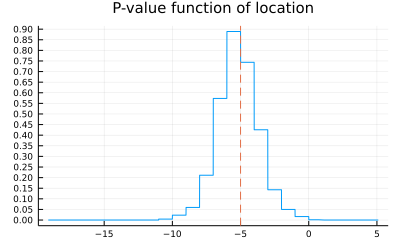

In [29]:
m, n = 10, 20
X, Y = rand(1:m, m), rand(1:n, n)
show_plot_brunner_munzel(X, Y)

(phat = 0.75,
 sehat = 0.11205157542647741,
 tvalue = 2.231115439907736,
 df = 18.0,
 p = 0.5,
 pvalue = 0.03863103202434314,
 α = 0.05,
 confint_p = [0.5145883755427825, 0.9854116244572175],
 confint_location = [-5.318179432610124, -0.05841508479073754])
median(X) = 1.3089930416807416
median(Y) = 2.9790059563220423


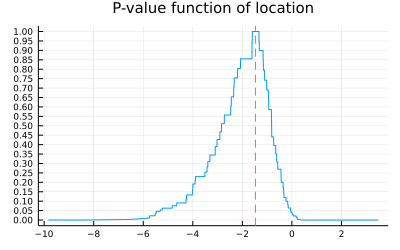

In [30]:
distx, disty = LogNormal(), LogNormal(1)
m, n = 10, 10
X, Y = rand(distx, m), rand(disty, n)
show_plot_brunner_munzel(X, Y)

(phat = 0.6912499999999999,
 sehat = 0.05960002903974512,
 tvalue = 3.208891053936604,
 df = 75.84080882915966,
 p = 0.5,
 pvalue = 0.001953574321225763,
 α = 0.05,
 confint_p = [0.5725422250913458, 0.8099577749086541],
 confint_location = [-2.07997163873439, -0.29464656357396524])
median(X) = 1.044779302249417
median(Y) = 2.2527593566191237


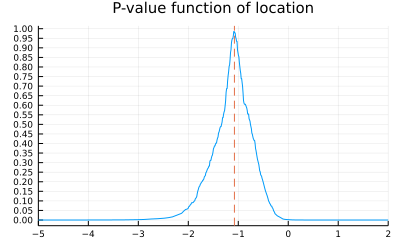

In [31]:
distx, disty = LogNormal(), LogNormal(1)
m, n = 40, 40
X, Y = rand(distx, m), rand(disty, n)
show_plot_brunner_munzel(X, Y; xlim=(-5, 2))

(phat = 0.79234375,
 sehat = 0.025077139980214335,
 tvalue = 11.657778767062629,
 df = 315.6587283148897,
 p = 0.5,
 pvalue = 2.3287816342563994e-26,
 α = 0.05,
 confint_p = [0.7430042840809774, 0.8416832159190226],
 confint_location = [-2.250313266911184, -1.404197630202607])
median(X) = 0.8417596982690712
median(Y) = 2.974128627007357


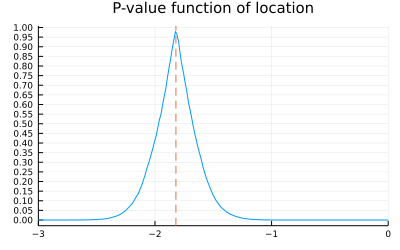

In [32]:
distx, disty = LogNormal(), LogNormal(1)
m, n = 160, 160
X, Y = rand(distx, m), rand(disty, n)
show_plot_brunner_munzel(X, Y; xlim=(-3, 0))

In [33]:
function sim_brunner_mumzel_and_welch(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 10^6)
    pval_bm = Vector{Float64}(undef, L)
    pval_w = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    tmpRRx = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpRRy = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval_bm[i] = pvalue_brunner_munzel(X, Y, tmpRRx[threadid()], tmpRRy[threadid()])
        pval_w[i] = pvalue_welch(X, Y)
    end
    ecdf(pval_bm), ecdf(pval_w)
end

function printcompact(io, xs...)
    print(IOContext(io, :compact => true), xs...)
end

function distname(dist)
    replace(sprint(printcompact, dist), r"\{[^\}]*\}"=>"")
end

function plot_ecdf(ecdf_pval, distx, disty, m, n, a;
        testname = "", kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:1)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    s = (a < 0 ? "" : "+") * string(round(a; digits=4))
    title!("$(testname)X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty))$s, n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 10^6, a = nothing, Δμ = nothing, kwargs...)
    @show (mean(distx), std(distx))
    @show (mean(disty), std(disty))
    
    if isnothing(a)
        @show a = tieshift(distx, disty)
        @show prob_x_le_y(distx, disty + a)
    else
        @show a
        @show median(distx) - median(disty)
    end
    if isnothing(Δμ)
        @show Δμ = mean(distx) - mean(disty)
        @show mean(distx), mean(disty + Δμ)
    else
        @show Δμ
        @show mean(distx), mean(disty + Δμ)
    end
        
    ecdf_bm, ecdf_w = @time sim_brunner_mumzel_and_welch(;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax = max(ecdf_bm(0.1), ecdf_w(0.1))
    P1 = plot_ecdf(ecdf_bm, distx, disty, m, n, a;
        testname="Brunner-Munzel test\n",
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_w, distx, disty, m, n, Δμ;
        testname="Welch t-test\n",
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 450), topmargin=3.5Plots.mm)
end

plot_pvals (generic function with 1 method)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.499253 seconds (95.42 k allocations: 50.937 MiB, 16.11% compilation time)


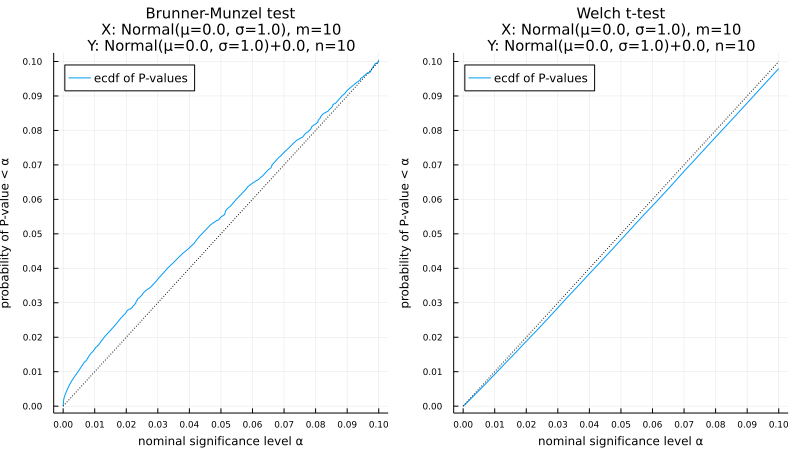

In [34]:
plot_pvals(; distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.399803 seconds (243 allocations: 45.801 MiB, 4.34% gc time)


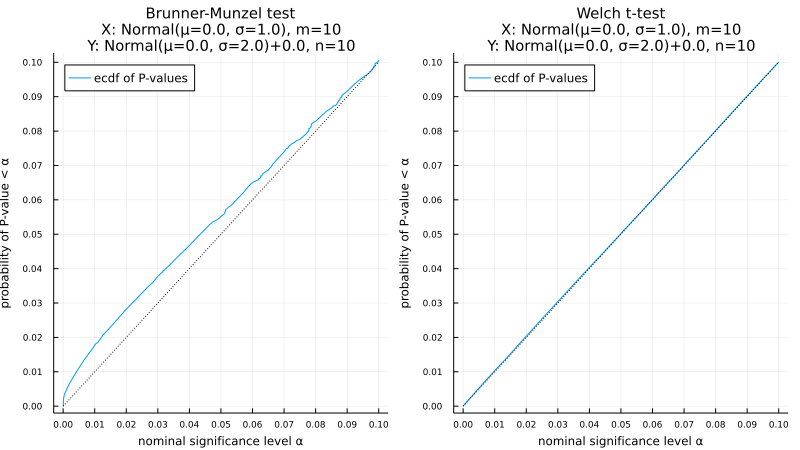

In [35]:
plot_pvals(; distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (4.4816890703380645, 5.874743663340262)
a = tieshift(distx, disty) = -1.4744426128871542
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = -2.8329677996379363
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.447886 seconds (39.72 k allocations: 47.867 MiB, 8.39% compilation time)


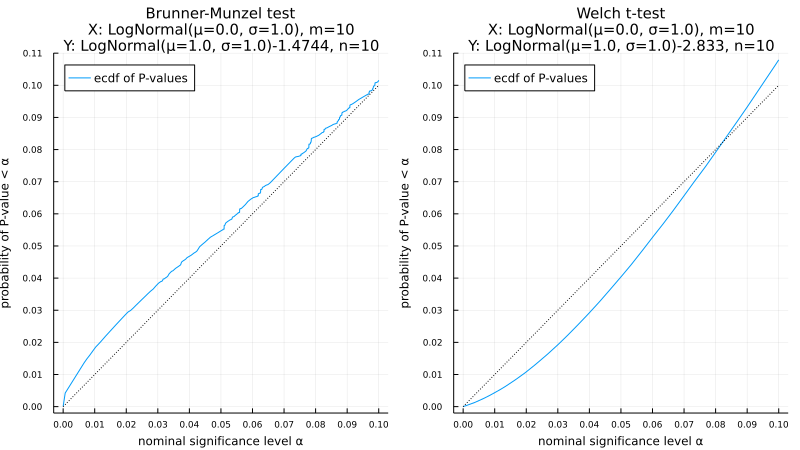

In [36]:
plot_pvals(; distx = LogNormal(), disty = LogNormal(1), m = 10, n = 10)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (4.4816890703380645, 5.874743663340262)
a = tieshift(distx, disty) = -1.4744426128871542
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = -2.8329677996379363
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.612691 seconds (243 allocations: 45.805 MiB, 2.40% gc time)


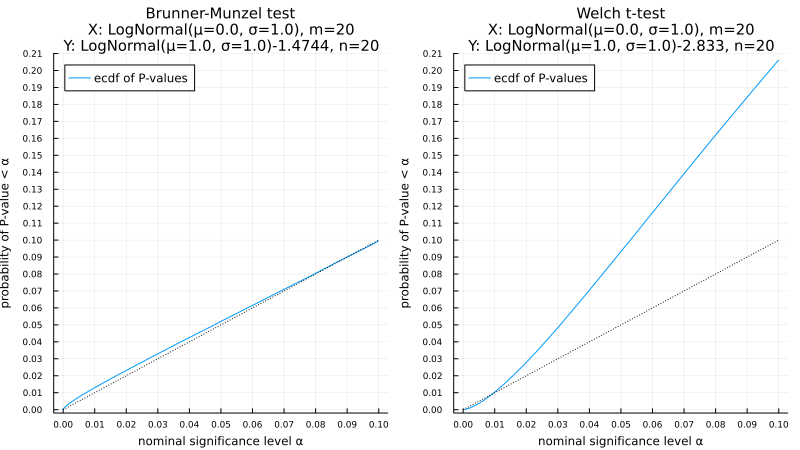

In [37]:
plot_pvals(; distx = LogNormal(), disty = LogNormal(1), m = 20, n = 20)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (4.4816890703380645, 5.874743663340262)
a = tieshift(distx, disty) = -1.4744426128871542
prob_x_le_y(distx, disty + a) = 0.5
Δμ = mean(distx) - mean(disty) = -2.8329677996379363
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.964165 seconds (235 allocations: 45.812 MiB)


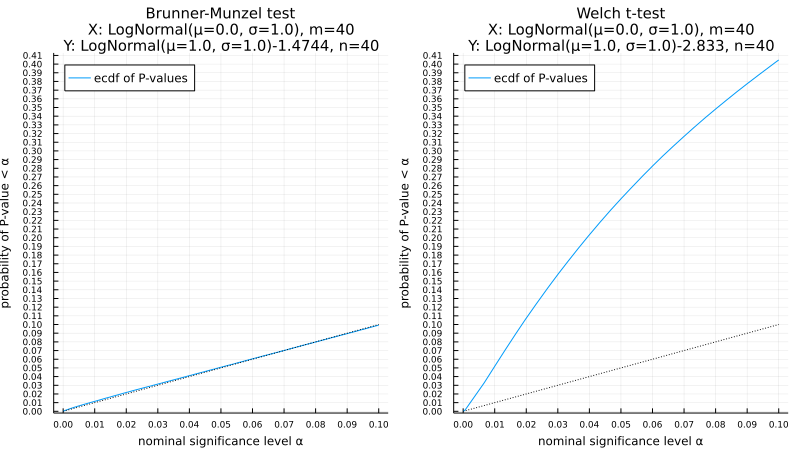

In [38]:
plot_pvals(; distx = LogNormal(), disty = LogNormal(1), m = 40, n = 40)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
Δμ = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.605761 seconds (426.86 k allocations: 68.594 MiB, 2.93% gc time, 26.75% compilation time)


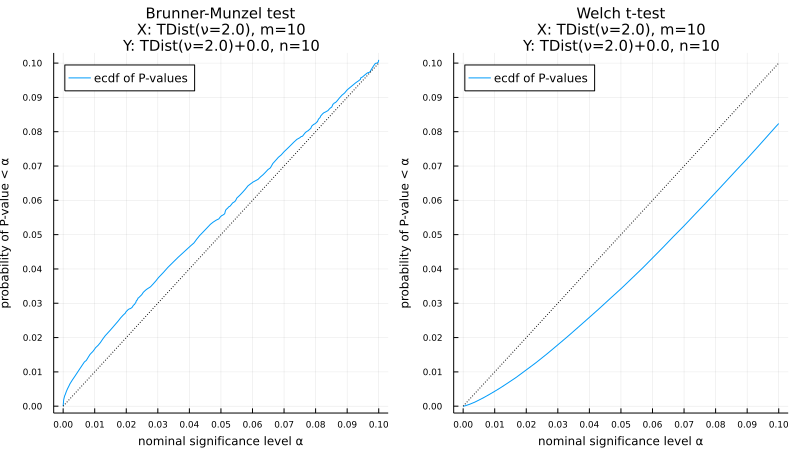

In [39]:
plot_pvals(; distx = TDist(2), disty = TDist(2), m = 10, n = 10, Δμ = 0.0)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = -3.4064499775914207e-9
prob_x_le_y(distx, disty + a) = 0.5
Δμ = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.526436 seconds (245 allocations: 45.801 MiB)


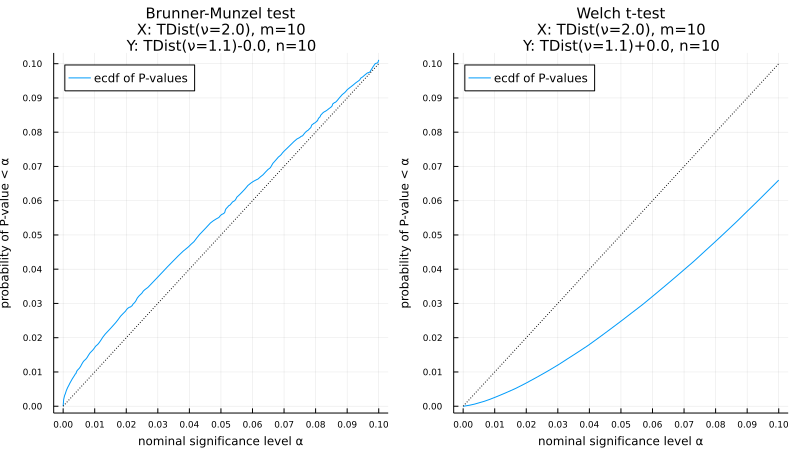

In [40]:
plot_pvals(; distx = TDist(2), disty = TDist(1.1), m = 10, n = 10, Δμ = 0.0)

a = tieshift(distx, disty) = -0.8414056600399943
  3.532078 seconds (477.14 k allocations: 71.375 MiB, 0.57% gc time, 4.11% compilation time)
a = median(distx) - median(disty) = -0.6931471805599453
  3.424772 seconds (243 allocations: 45.835 MiB, 0.45% gc time)


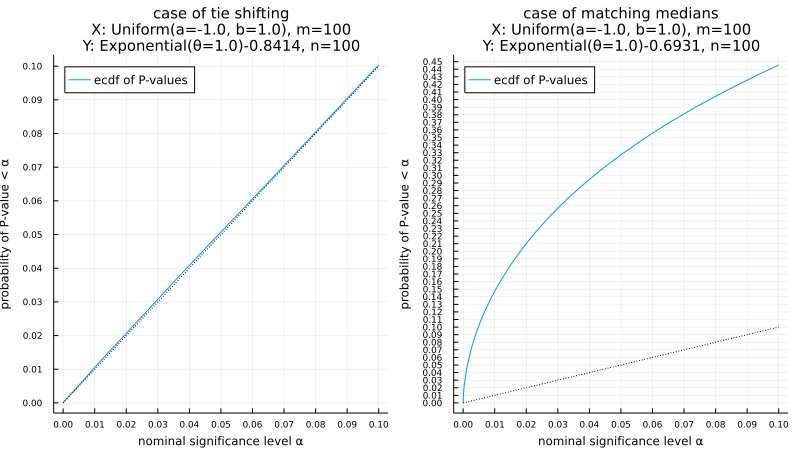

In [41]:
distx, disty = Uniform(-1, 1), Exponential()
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1, _ = @time sim_brunner_mumzel_and_welch(;
    distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, distx, disty, m, n, a;
    testname="case of tie shifting\n")

@show a = median(distx) - median(disty)
ecdf_pval2, _ = @time sim_brunner_mumzel_and_welch(;
    distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, distx, disty, m, n, a;
    testname="case of matching medians\n")

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=1.0), 1.0)
tieshift(distx, disty) = -0.8414056600399943
median(distx) - median(disty) = -0.6931471805599453


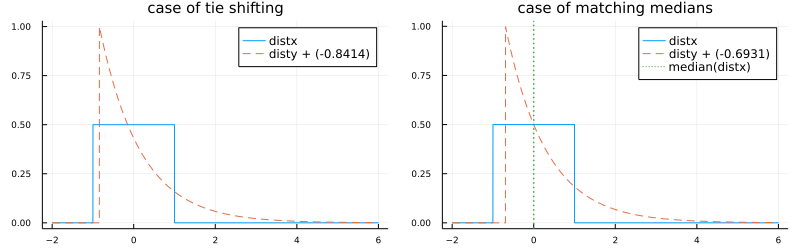

In [42]:
distx, disty = Uniform(-1, 1), Exponential()
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

a = tieshift(distx, disty) = -2.814168911097315
  3.447058 seconds (245 allocations: 45.835 MiB)
a = median(distx) - median(disty) = -2.772588722239781
  3.479423 seconds (242 allocations: 45.835 MiB, 0.43% gc time)


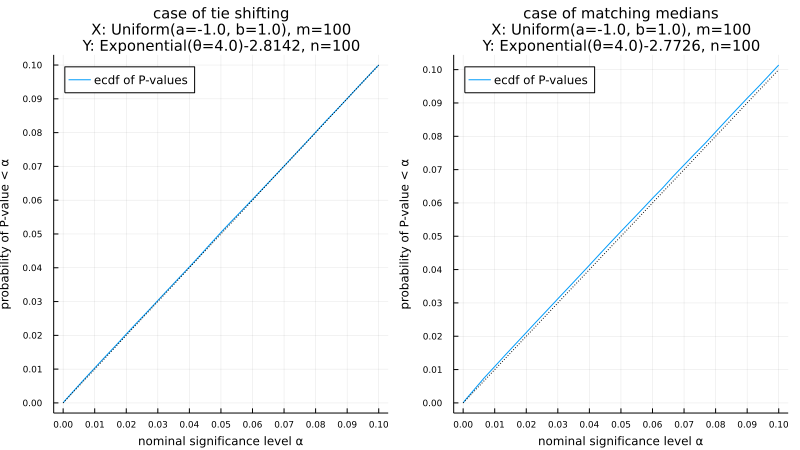

In [43]:
distx, disty = Uniform(-1, 1), Exponential(4)
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1, _ = @time sim_brunner_mumzel_and_welch(;
    distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, distx, disty, m, n, a;
    testname="case of tie shifting\n")

@show a = median(distx) - median(disty)
ecdf_pval2, _ = @time sim_brunner_mumzel_and_welch(;
    distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, distx, disty, m, n, a;
    testname="case of matching medians\n")

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=4.0), 4.0)
tieshift(distx, disty) = -2.814168911097315
median(distx) - median(disty) = -2.772588722239781


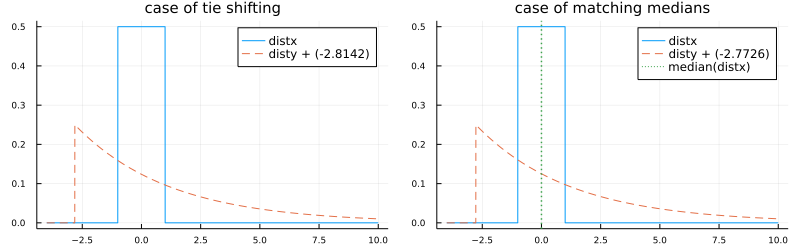

In [44]:
distx, disty = Uniform(-1, 1), Exponential(4)
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

In [45]:
function plot_confints(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 100, kwargs...)
    a = tieshift(distx, disty)
    Δμ = mean(distx) - mean(disty)
    BM = fill(zeros(2), 0)
    W = fill(zeros(2), 0)
    for _ in 1:L
        X = rand(distx, m)
        Y = rand(disty, n)
        push!(BM, brunner_munzel(X, Y .+ a).confint_location)
        push!(W, confint_welch(X, Y .+ Δμ))
    end
    P = plot()
    for i in 1:L
        plot!(fill(i, 2), [first(BM[i]), last(BM[i])]; label="", c=1, lw=2)
        plot!(fill(i+0.3, 2), [first(W[i]), last(W[i])]; label="", c=2, lw=2)
    end
    title!("X: $(distname(distx)), m=$m,   Y: $(distname(disty)), n=$n")
    plot!(size=(1000, 250))
end

plot_confints (generic function with 1 method)

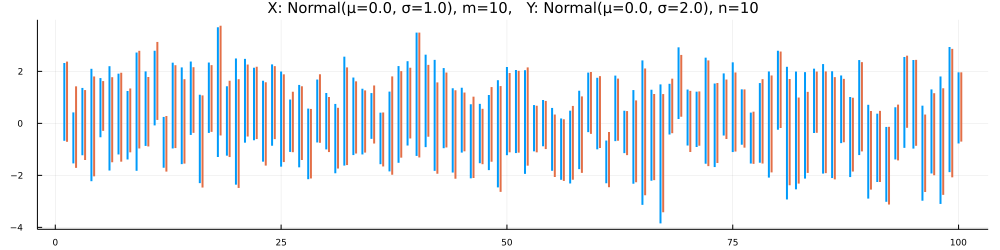

In [46]:
plot_confints(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

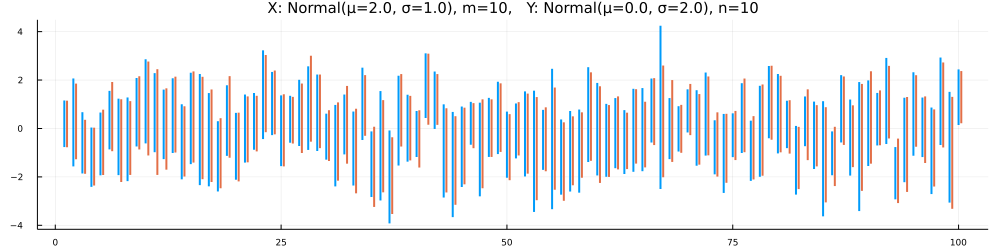

In [47]:
plot_confints(distx = Normal(2, 1), disty = Normal(0, 2), m = 10, n = 10)

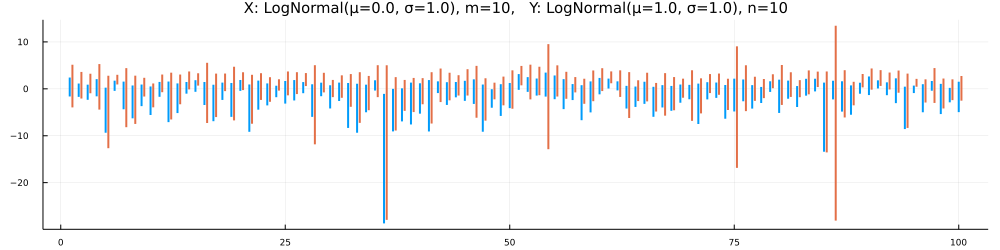

In [48]:
plot_confints(distx = LogNormal(0), disty = LogNormal(1), m = 10, n = 10)

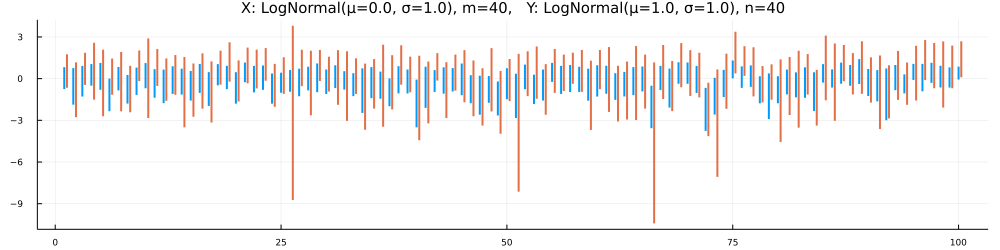

In [49]:
plot_confints(distx = LogNormal(0), disty = LogNormal(1), m = 40, n = 40)

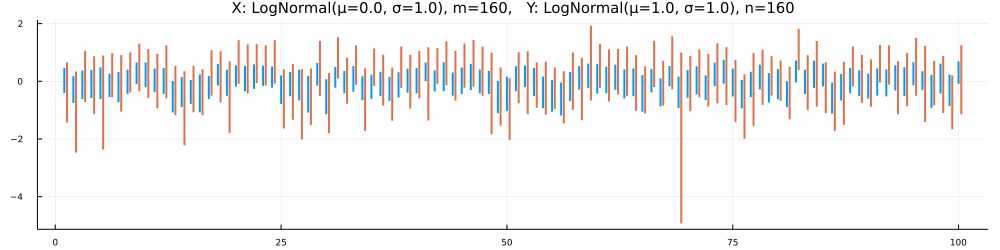

In [50]:
plot_confints(distx = LogNormal(0), disty = LogNormal(1), m = 160, n = 160)

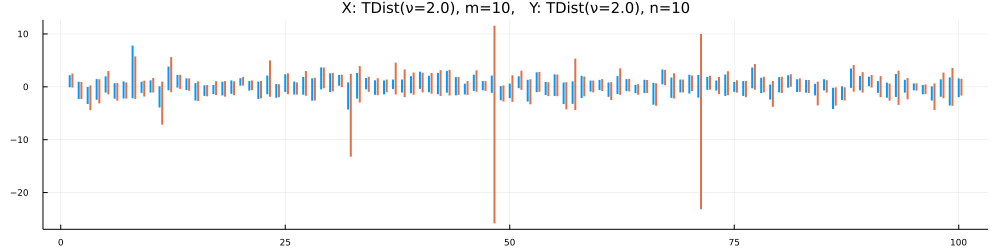

In [51]:
plot_confints(distx = TDist(2), disty = TDist(2), m = 10, n = 10)

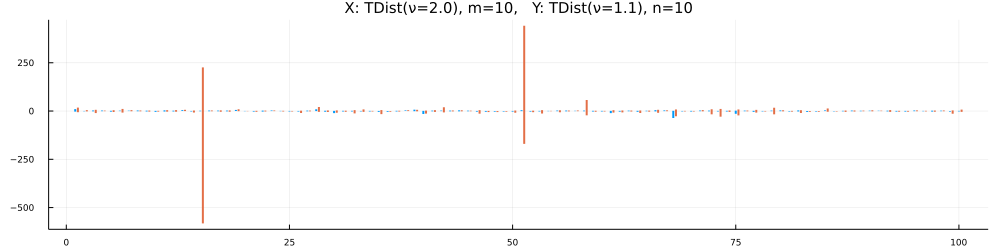

In [52]:
plot_confints(distx = TDist(2), disty = TDist(1.1), m = 10, n = 10)

In [53]:
function plot_limits(;
        distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10,
        L = 1000, kwargs...)
    
    @show distx, m
    @show disty, n

    a = tieshift(distx, disty)
    Δμ = mean(distx) - mean(disty)

    BM = fill(zeros(2), 0)
    W = fill(zeros(2), 0)
    for _ in 1:L
        X = rand(distx, m)
        Y = rand(disty, n)
        push!(BM, brunner_munzel(X, Y .+ a).confint_location)
        push!(W, confint_welch(X, Y .+ Δμ))
    end

    lower = [(first(BM[i]), first(W[i])) for i in 1:L]
    upper = [(last(BM[i]), last(W[i])) for i in 1:L]

    P1 = scatter(lower; label="", msc=:auto, ms=2, ma=0.5)
    plot!(identity; label="")
    plot!(xguide="Brunner-Munzel", yguide="Welch")
    title!("lower")

    P2 = scatter(upper; label="", msc=:auto, ms=2, ma=0.5)
    plot!(identity; label="")
    plot!(xguide="Brunner-Munzel", yguide="Welch")
    title!("upper")

    plot(P1, P2; size=(640, 320))
end

plot_limits (generic function with 1 method)

(distx, m) = (Normal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=2.0), 10)


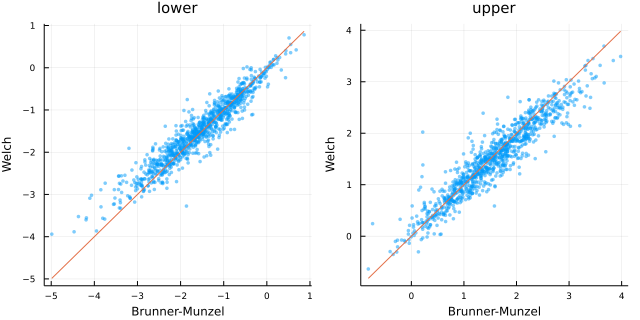

In [54]:
plot_limits(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

(distx, m) = (Normal{Float64}(μ=2.0, σ=1.0), 10)
(disty, n) = (Normal{Float64}(μ=0.0, σ=2.0), 10)


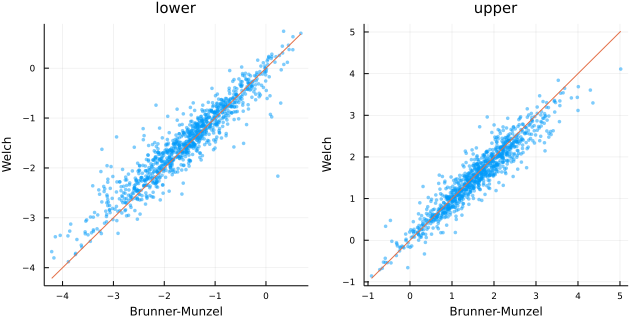

In [55]:
plot_limits(distx = Normal(2, 1), disty = Normal(0, 2), m = 10, n = 10)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 10)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 10)


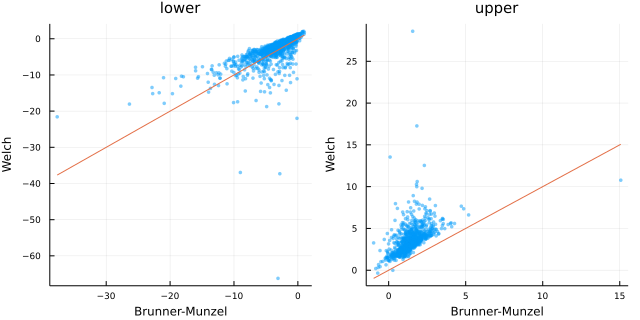

In [56]:
plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 10, n = 10)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 40)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 40)


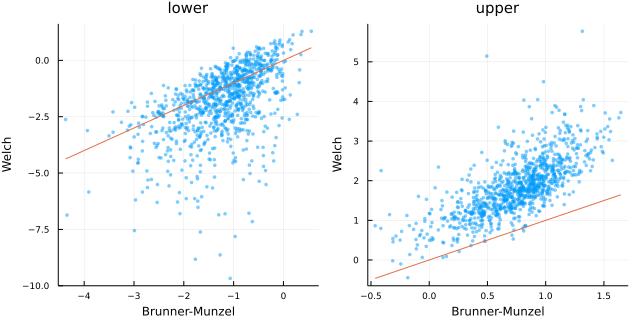

In [57]:
plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 40, n = 40)

(distx, m) = (LogNormal{Float64}(μ=0.0, σ=1.0), 160)
(disty, n) = (LogNormal{Float64}(μ=1.0, σ=1.0), 160)
  6.602360 seconds (61.68 k allocations: 38.644 MiB)


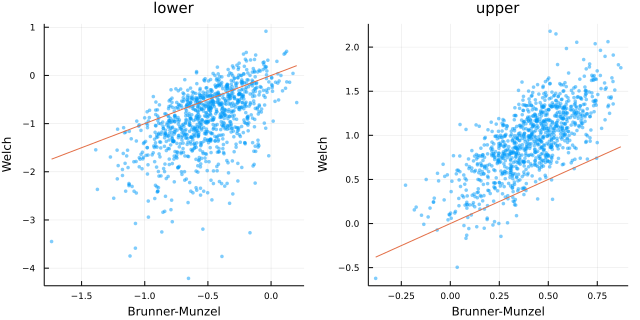

In [58]:
@time plot_limits(distx = LogNormal(), disty = LogNormal(1), m = 160, n = 160)

(distx, m) = (TDist{Float64}(ν=2.0), 10)
(disty, n) = (TDist{Float64}(ν=2.0), 10)


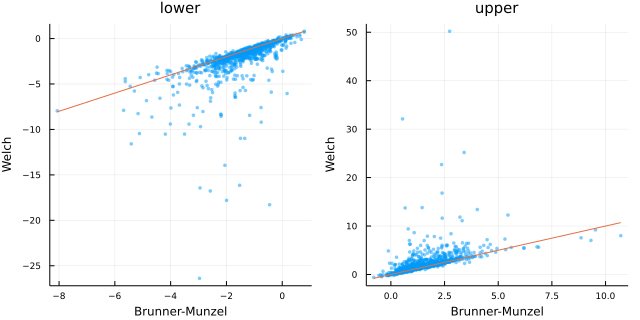

In [59]:
plot_limits(distx = TDist(2), disty = TDist(2), m = 10, n = 10)

(distx, m) = (TDist{Float64}(ν=2.0), 10)
(disty, n) = (TDist{Float64}(ν=1.1), 10)


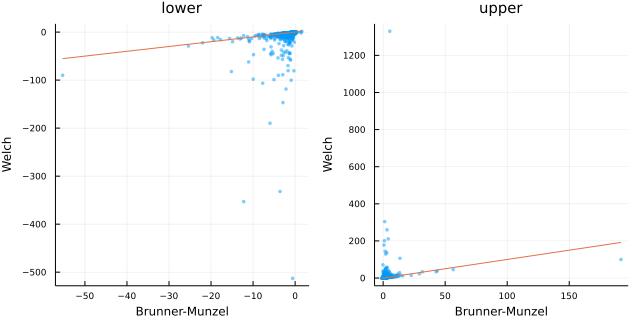

In [60]:
plot_limits(distx = TDist(2), disty = TDist(1.1), m = 10, n = 10)